# LightGCN Implementation

Number of Users: 6022, Number of Items: 3043

Starting LightGCN training...
778/778 ━━━━━━━━━━━━━━━━━━━━ 82s 106ms/step - loss: 0.3990
Epoch 1/10 completed. Average loss: 0.399017
Epoch 1: Recall@20: 0.102717, NDCG@20: 0.262303
778/778 ━━━━━━━━━━━━━━━━━━━━ 82s 106ms/step - loss: 0.3121
Epoch 2/10 completed. Average loss: 0.312114
Epoch 2: Recall@20: 0.112149, NDCG@20: 0.275294
778/778 ━━━━━━━━━━━━━━━━━━━━ 82s 106ms/step - loss: 0.2834
Epoch 3/10 completed. Average loss: 0.283383
Epoch 3: Recall@20: 0.120649, NDCG@20: 0.285427
778/778 ━━━━━━━━━━━━━━━━━━━━ 82s 106ms/step - loss: 0.2642
Epoch 4/10 completed. Average loss: 0.264153
Epoch 4: Recall@20: 0.125788, NDCG@20: 0.291062
778/778 ━━━━━━━━━━━━━━━━━━━━ 82s 106ms/step - loss: 0.2513
Epoch 5/10 completed. Average loss: 0.251279
Epoch 5: Recall@20: 0.127458, NDCG@20: 0.289676
778/778 ━━━━━━━━━━━━━━━━━━━━ 82s 106ms/step - loss: 0.2430
Epoch 6/10 completed. Average loss: 0.243046
Epoch 6: Recall@20: 0.129698, NDCG@20: 0.290336
778/778 ━━━━

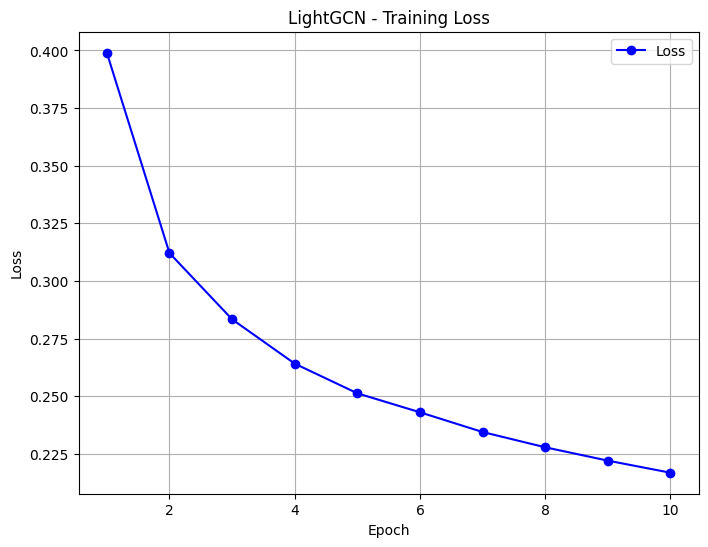

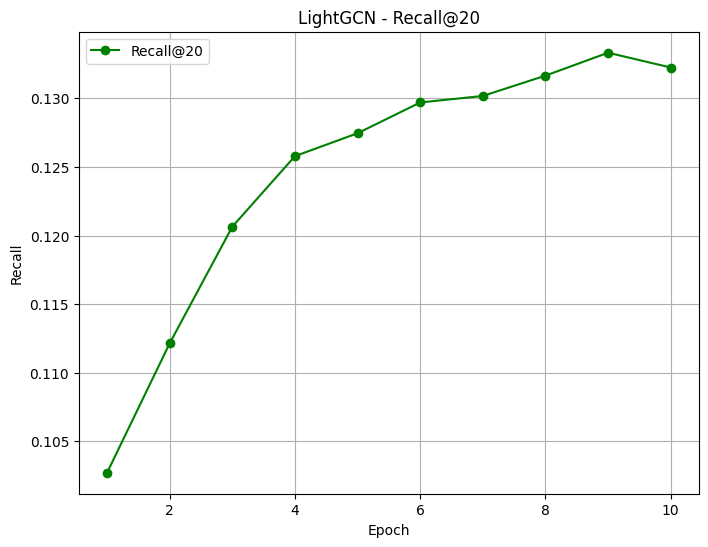

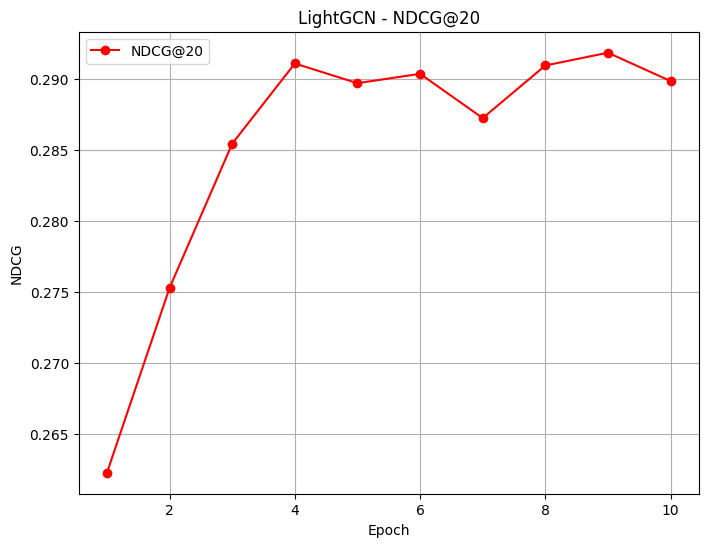


Evaluating on test data...

Evaluation Results (k=20):
  Recall@20:    0.132573
  NDCG@20:      0.298356

User and item embeddings saved.


In [ ]:
import json
import numpy as np
import scipy.sparse as sp
import tensorflow as tf
import random
from tensorflow.keras.utils import Progbar
import matplotlib.pyplot as plt
from collections import defaultdict

def load_mydataset(train_file, test_file, val_file):
    def read_json(path):
        with open(path, 'r') as f:
            return [set(x) for x in json.load(f)]

    train_list = read_json(train_file)
    test_list = read_json(test_file)
    val_list = read_json(val_file)

    train_items = {item for items in train_list for item in items}

    def filter_orphans(data_list, valid_items):
        # remove items not in train set
        return [{item for item in items if item in valid_items} for items in data_list]

    test_list = filter_orphans(test_list, train_items)
    val_list = filter_orphans(val_list, train_items)

    n_users = len(train_list)
    n_items = max(train_items) + 1 if train_items else 0

    return train_list, test_list, val_list, n_users, n_items

def build_adjacency_matrix(train_data, n_users, n_items):
    # create a bipartite adjacency matrix [0, R; R^T, 0].

    R_dok = sp.dok_matrix((n_users, n_items), dtype=np.float32)
    for u, items in enumerate(train_data):
        for i in items:
            R_dok[u, i] = 1.0
    R_csr = R_dok.tocsr()

    adj_size = n_users + n_items
    adj_dok = sp.dok_matrix((adj_size, adj_size), dtype=np.float32)
    # Place R in the upper-right block
    adj_dok[:n_users, n_users:] = R_csr
    # Place R^T in the lower-left block
    adj_dok[n_users:, :n_users] = R_csr.transpose()
    return adj_dok.tocsr()


def normalize_adj_sym(adj_mat):
    # symmetric normalization: D^-1/2 * A * D^-1/2.
    rowsum = np.array(adj_mat.sum(axis=1)).flatten() + 1e-9
    d_inv_sqrt = np.power(rowsum, -0.5)
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.0
    D_inv_sqrt = sp.diags(d_inv_sqrt)
    return D_inv_sqrt.dot(adj_mat).dot(D_inv_sqrt)

class LightGCNModel(tf.keras.Model):
    def __init__(self, n_users, n_items, adj_mat, n_layers=3, emb_dim=64, decay=1e-4, use_personalized_alpha=False):
        super().__init__()
        self.n_users = n_users
        self.n_items = n_items
        self.adj_mat = adj_mat  # TF SparseTensor
        self.n_layers = n_layers
        self.emb_dim = emb_dim
        self.decay = decay
        self.use_personalized_alpha = use_personalized_alpha

        initializer = tf.initializers.GlorotUniform()
        self.user_embedding = self.add_weight(
            name='user_embedding',
            shape=(n_users, emb_dim),
            initializer=initializer,
            trainable=True
        )
        self.item_embedding = self.add_weight(
            name='item_embedding',
            shape=(n_items, emb_dim),
            initializer=initializer,
            trainable=True
        )

        if use_personalized_alpha:
            self.alpha_mlp = tf.keras.Sequential([
                tf.keras.layers.Dense(n_layers + 1, activation='softmax')
            ])

    def call(self, embeddings):
        user_emb, item_emb = embeddings
        all_emb = tf.concat([user_emb, item_emb], axis=0)
        emb_list = [all_emb]

        # propagation layers
        for _ in range(self.n_layers):
            all_emb = tf.sparse.sparse_dense_matmul(self.adj_mat, all_emb)
            emb_list.append(all_emb)

        # combine embeddings from different layers
        if not self.use_personalized_alpha:
            # uniform average of all (K+1) layers
            alpha_k = 1.0 / (self.n_layers + 1)
            alpha_weights = [alpha_k] * (self.n_layers + 1)
            alpha_weights = tf.convert_to_tensor(alpha_weights, dtype=tf.float32)
            alpha_weights = tf.reshape(alpha_weights, (-1, 1, 1))
            stacked_emb = tf.stack(emb_list, axis=0)  # (K+1, n_users+n_items, emb_dim)
            combined_emb = tf.reduce_sum(stacked_emb * alpha_weights, axis=0)
        else:
            # personalized alpha for each layer
            # incomplete for per-user (just example)
            alpha = self.alpha_mlp(emb_list[0])
            alpha = tf.expand_dims(alpha, axis=-1)
            stacked_emb = tf.stack(emb_list, axis=0)
            combined_emb = tf.reduce_sum(stacked_emb * alpha, axis=0)

        user_final, item_final = tf.split(combined_emb, [self.n_users, self.n_items], axis=0)
        return user_final, item_final

    def recommend(self, user_ids, k=10):
        updated_user_emb, updated_item_emb = self((self.user_embedding, self.item_embedding))
        user_vecs = tf.gather(updated_user_emb, user_ids)

        all_recs = []
        for idx, uid in enumerate(user_ids):
            u_vec = user_vecs[idx:idx + 1]
            scores = tf.matmul(u_vec, updated_item_emb, transpose_b=True)  # shape=(1, n_items)
            scores_np = scores.numpy().flatten()
            idx_topk = np.argsort(scores_np)[::-1][:k]
            score_topk = scores_np[idx_topk]
            for item_id, sc in zip(idx_topk, score_topk):
                all_recs.append((int(uid), int(item_id), float(sc)))
        return all_recs


def sample_neg(pos_items, n_items, strategy='random'):
    if strategy == 'random':
        neg_item = random.randint(0, n_items - 1)
        while neg_item in pos_items:
            neg_item = random.randint(0, n_items - 1)
    return neg_item


def train_lightgcn(model, train_data, val_data, n_users, n_items, batch_size=1024, epochs=10, initial_lr=1e-2, k=20):
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=initial_lr,
        decay_steps=1000,
        decay_rate=0.96,
        staircase=True
    )
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    train_pairs = [(u, i) for u in range(n_users) for i in train_data[u]]
    steps_per_epoch = len(train_pairs) // batch_size + (len(train_pairs) % batch_size != 0)

    epoch_losses = []
    recall_scores = []
    ndcg_scores = []

    for epoch in range(1, epochs + 1):
        random.shuffle(train_pairs)
        progbar = Progbar(steps_per_epoch)

        epoch_loss = 0
        for step in range(steps_per_epoch):
            batch_slice = train_pairs[step * batch_size:(step + 1) * batch_size]
            users = [u for (u, _) in batch_slice]
            pos_items = [i for (_, i) in batch_slice]
            neg_items = [sample_neg(train_data[u], n_items) for (u, _) in batch_slice]

            users = np.array(users, dtype=np.int32)
            pos_items = np.array(pos_items, dtype=np.int32)
            neg_items = np.array(neg_items, dtype=np.int32)

            with tf.GradientTape() as tape:
                user_emb, item_emb = model((model.user_embedding, model.item_embedding))
                u_emb = tf.nn.embedding_lookup(user_emb, users)
                pos_emb = tf.nn.embedding_lookup(item_emb, pos_items)
                neg_emb = tf.nn.embedding_lookup(item_emb, neg_items)

                # BPR loss
                pos_scores = tf.reduce_sum(u_emb * pos_emb, axis=1)
                neg_scores = tf.reduce_sum(u_emb * neg_emb, axis=1)
                mf_loss = tf.reduce_mean(tf.nn.softplus(neg_scores - pos_scores))

                # L2 Regularization
                reg_loss = model.decay * (
                    tf.nn.l2_loss(u_emb) + tf.nn.l2_loss(pos_emb) + tf.nn.l2_loss(neg_emb)
                ) / batch_size

                loss = mf_loss + reg_loss

            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            epoch_loss += loss.numpy()
            progbar.add(1, values=[('loss', float(loss))])

        avg_epoch_loss = epoch_loss / steps_per_epoch
        epoch_losses.append(avg_epoch_loss)
        print(f"Epoch {epoch}/{epochs} completed. Average loss: {avg_epoch_loss:.6f}")

        # evaluate on validation set
        val_users = [u for u in range(n_users) if len(val_data[u]) > 0]
        val_recs = model.recommend(val_users, k=k)
        epoch_recall = recall_at_k(val_recs, val_data, k=k)
        epoch_ndcg = ndcg(val_recs, val_data, k=k)

        recall_scores.append(epoch_recall)
        ndcg_scores.append(epoch_ndcg)
        print(f"Epoch {epoch}: Recall@{k}: {epoch_recall:.6f}, NDCG@{k}: {epoch_ndcg:.6f}")

    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o', linestyle='-', color='b', label="Loss")
    plt.title("LightGCN - Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(recall_scores) + 1), recall_scores, marker='o', linestyle='-', color='g', label=f"Recall@{k}")
    plt.title(f"LightGCN - Recall@{k}")
    plt.xlabel("Epoch")
    plt.ylabel("Recall")
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(ndcg_scores) + 1), ndcg_scores, marker='o', linestyle='-', color='r', label=f"NDCG@{k}")
    plt.title(f"LightGCN - NDCG@{k}")
    plt.xlabel("Epoch")
    plt.ylabel("NDCG")
    plt.grid(True)
    plt.legend()
    plt.show()

    return epoch_losses, recall_scores, ndcg_scores

def recall_at_k(recs, test_data, k=10):
    user_recs = defaultdict(list)
    for (u, i, s) in recs:
        user_recs[u].append(i)
    recalls = []
    for u, items_pred in user_recs.items():
        if len(test_data[u]) == 0:
            continue
        if k > 0:
            items_pred = items_pred[:k]
        gt = test_data[u]
        num_hit = len(set(items_pred).intersection(gt))
        recalls.append(num_hit / float(len(gt)))
    return np.mean(recalls) if recalls else 0.0

def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(r / np.log2(np.arange(2, r.size + 2)))
    return 0.

def ndcg_at_k(recommended, ground_truth, k=10):
    rel = [1 if i in ground_truth else 0 for i in recommended[:k]]
    ideal_rel = sorted(rel, reverse=True)
    dcg = dcg_at_k(rel, k)
    idcg = dcg_at_k(ideal_rel, k)
    return (dcg / idcg) if idcg > 0 else 0.0

def ndcg(recs, test_data, k=10):
    user_recs = defaultdict(list)
    for (u, i, s) in recs:
        user_recs[u].append(i)
    ndcgs = []
    for u, items_pred in user_recs.items():
        gt = test_data[u]
        if len(gt) == 0:
            continue
        ndcgs.append(ndcg_at_k(items_pred, gt, k))
    return np.mean(ndcgs) if ndcgs else 0.0


def evaluate_lightgcn(model, users, test_data, ks=[5, 10, 20], batch_size=2000):
    all_recs = []
    idx_start = 0
    max_k = max(ks)
    while idx_start < len(users):
        idx_end = min(idx_start + batch_size, len(users))
        user_batch = users[idx_start:idx_end]
        recs_chunk = model.recommend(user_batch, k=max_k)
        all_recs.extend(recs_chunk)
        idx_start = idx_end

    results = {}
    for k in ks:

        rec = recall_at_k(all_recs, test_data, k=k)
        ndcg_ = ndcg(all_recs, test_data, k=k)
        results[k] = (rec, ndcg_)
        print(f"\nEvaluation Results (k={k}):")
        print(f"  Recall@{k}:    {rec:.6f}")
        print(f"  NDCG@{k}:      {ndcg_:.6f}")

    return results


train_file = '/kaggle/input/dataset-movielens/train_data.json'
test_file = '/kaggle/input/dataset-movielens/test_data.json'
val_file = '/kaggle/input/dataset-movielens/validation_data.json'

train_data, test_data, val_data, n_users, n_items = load_mydataset(
    train_file, test_file, val_file
)
print(f"Number of Users: {n_users}, Number of Items: {n_items}")

adj_csr = build_adjacency_matrix(train_data, n_users, n_items)
norm_adj_csr = normalize_adj_sym(adj_csr)

# convert to TensorFlow SparseTensor
coo = norm_adj_csr.tocoo().astype(np.float32)
indices = np.vstack((coo.row, coo.col)).transpose()
A_tilde = tf.sparse.SparseTensor(indices=indices, values=coo.data, dense_shape=coo.shape)
A_tilde = tf.sparse.reorder(A_tilde)

N_LAYERS = 4
EMBED_DIM = 64
DECAY = 1e-3
INITIAL_LR = 1e-2
EPOCHS = 10
BATCH_SIZE = 1024

model = LightGCNModel(
    n_users=n_users,
    n_items=n_items,
    adj_mat=A_tilde,
    n_layers=N_LAYERS,
    emb_dim=EMBED_DIM,
    decay=DECAY,
    use_personalized_alpha=False
)

print("\nStarting LightGCN training...")
train_lightgcn(
    model=model,
    train_data=train_data,
    val_data=val_data,
    n_users=n_users,
    n_items=n_items,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    initial_lr=INITIAL_LR,
    k=20
)

print("\nEvaluating on test data...")
test_users = [u for u in range(n_users) if len(test_data[u]) > 0]
_ = evaluate_lightgcn(model, test_users, test_data, ks=[20])


user_emb, item_emb = model((model.user_embedding, model.item_embedding))
np.save("lightgcn_user_embeddings.npy", user_emb.numpy())
np.save("lightgcn_item_embeddings.npy", item_emb.numpy())
print("\nUser and item embeddings saved.")

# Hyperparameter Tuning

In [ ]:
from itertools import product

def hyperparameter_tuning_lightgcn(train_data, val_data, n_users, n_items, adj_mat, param_grid, patience=5, max_epochs=50, k=20):
    best_params = None
    best_metrics = {"ndcg": 0.0, "recall": 0.0}
    best_epoch = 0

    param_combinations = list(product(*param_grid.values()))

    for params in param_combinations:
        n_layers, emb_dim, decay, initial_lr, batch_size = params
        print(f"\nTrying parameters: Layers={n_layers}, Embedding={emb_dim}, Decay={decay}, LR={initial_lr}, Batch Size={batch_size}")

        model = LightGCNModel(
            n_users=n_users,
            n_items=n_items,
            adj_mat=adj_mat,
            n_layers=n_layers,
            emb_dim=emb_dim,
            decay=decay
        )

        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=initial_lr,
            decay_steps=1000,
            decay_rate=0.96,
            staircase=True
        )
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

        # training data (user, item) pairs
        train_pairs = [(u, i) for u in range(n_users) for i in train_data[u]]
        steps_per_epoch = len(train_pairs) // batch_size + (len(train_pairs) % batch_size != 0)

        no_improvement_epochs = 0
        best_val_ndcg = 0.0
        best_val_recall = 0.0

        for epoch in range(1, max_epochs + 1):
            random.shuffle(train_pairs)
            epoch_loss = 0

            # training loop
            for step in range(steps_per_epoch):
                batch_slice = train_pairs[step * batch_size:(step + 1) * batch_size]
                users = [u for (u, _) in batch_slice]
                pos_items = [i for (_, i) in batch_slice]
                neg_items = [sample_neg(train_data[u], n_items) for (u, _) in batch_slice]

                users = np.array(users, dtype=np.int32)
                pos_items = np.array(pos_items, dtype=np.int32)
                neg_items = np.array(neg_items, dtype=np.int32)

                with tf.GradientTape() as tape:
                    user_emb, item_emb = model((model.user_embedding, model.item_embedding))
                    u_emb = tf.nn.embedding_lookup(user_emb, users)
                    pos_emb = tf.nn.embedding_lookup(item_emb, pos_items)
                    neg_emb = tf.nn.embedding_lookup(item_emb, neg_items)

                    pos_scores = tf.reduce_sum(u_emb * pos_emb, axis=1)
                    neg_scores = tf.reduce_sum(u_emb * neg_emb, axis=1)
                    mf_loss = tf.reduce_mean(tf.nn.softplus(neg_scores - pos_scores))

                    reg_loss = model.decay * (
                        tf.nn.l2_loss(u_emb) + tf.nn.l2_loss(pos_emb) + tf.nn.l2_loss(neg_emb)
                    ) / batch_size
                    loss = mf_loss + reg_loss

                grads = tape.gradient(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(grads, model.trainable_variables))

                epoch_loss += loss.numpy()

            print(f"Epoch {epoch}/{max_epochs}")

            # validation evaluation
            val_users = [u for u in range(n_users) if len(val_data[u]) > 0]
            val_recs = []
            for i in range(0, len(val_users), 2000):
                user_batch = val_users[i:i + 2000]
                val_recs.extend(model.recommend(user_batch, k=k))

            val_ndcg = ndcg(val_recs, val_data, k=k)
            val_recall = recall_at_k(val_recs, val_data, k=k)
            print(f"Validation NDCG@{k}: {val_ndcg:.6f}, Recall@{k}: {val_recall:.6f}")

            if val_ndcg > best_val_ndcg or val_recall > best_val_recall:
                best_val_ndcg = max(val_ndcg, best_val_ndcg)
                best_val_recall = max(val_recall, best_val_recall)
                no_improvement_epochs = 0
                best_model_params = model.get_weights()
                best_epoch = epoch
            else:
                no_improvement_epochs += 1

            if no_improvement_epochs >= patience:
                print(f"Early stopping at epoch {epoch}. Best NDCG@{k}: {best_val_ndcg:.6f}, Recall@{k}: {best_val_recall:.6f}")
                break

        if best_val_ndcg > best_metrics["ndcg"] or best_val_recall > best_metrics["recall"]:
            best_params = params
            best_metrics = {"ndcg": best_val_ndcg, "recall": best_val_recall}

    print(f"\nBest Parameters: Layers={best_params[0]}, Embedding={best_params[1]}, Decay={best_params[2]}, LR={best_params[3]}, Batch Size={best_params[4]}")
    print(f"Best Validation Metrics: NDCG@{k}={best_metrics['ndcg']:.6f}, Recall@{k}={best_metrics['recall']:.6f}")
    return best_params, best_metrics


param_grid = {
    "n_layers": [2, 3, 4],
    "emb_dim": [32, 64, 128],
    "decay": [1e-4, 1e-5, 1e-6],
    "initial_lr": [1e-3, 1e-2],
    "batch_size": [1024]
}

best_params, best_metrics = hyperparameter_tuning_lightgcn(
    train_data=train_data,
    val_data=val_data,
    n_users=n_users,
    n_items=n_items,
    adj_mat=A_tilde,
    param_grid=param_grid,
    patience=5,
    max_epochs=5,
    k=20
)



Trying parameters: Layers=2, Embedding=32, Decay=0.0001, LR=0.001, Batch Size=1024
Epoch 1/5
Validation NDCG@20: 0.224741, Recall@20: 0.081303
Epoch 2/5
Validation NDCG@20: 0.226790, Recall@20: 0.082249
Epoch 3/5
Validation NDCG@20: 0.225988, Recall@20: 0.082033
Epoch 4/5
Validation NDCG@20: 0.227374, Recall@20: 0.082966
Epoch 5/5
Validation NDCG@20: 0.231505, Recall@20: 0.084536

Trying parameters: Layers=2, Embedding=32, Decay=0.0001, LR=0.01, Batch Size=1024
Epoch 1/5
Validation NDCG@20: 0.268015, Recall@20: 0.106913
Epoch 2/5
Validation NDCG@20: 0.280007, Recall@20: 0.116667
Epoch 3/5
Validation NDCG@20: 0.287598, Recall@20: 0.125270
Epoch 4/5
Validation NDCG@20: 0.289954, Recall@20: 0.127295
Epoch 5/5
Validation NDCG@20: 0.289171, Recall@20: 0.126902

Trying parameters: Layers=2, Embedding=32, Decay=1e-05, LR=0.001, Batch Size=1024
Epoch 1/5
Validation NDCG@20: 0.225397, Recall@20: 0.081118
Epoch 2/5
Validation NDCG@20: 0.224247, Recall@20: 0.080086
Epoch 3/5
Validation NDCG@20: 

In [ ]:
from itertools import product

def hyperparameter_tuning_lightgcn(train_data, val_data, n_users, n_items, adj_mat, param_grid, patience=5, max_epochs=50, k=20):
    best_params = None
    best_metrics = {"ndcg": 0.0, "recall": 0.0}
    best_epoch = 0

    param_combinations = list(product(*param_grid.values()))

    for params in param_combinations:
        n_layers, emb_dim, decay, initial_lr, batch_size = params
        print(f"\nTrying parameters: Layers={n_layers}, Embedding={emb_dim}, Decay={decay}, LR={initial_lr}, Batch Size={batch_size}")

        model = LightGCNModel(
            n_users=n_users,
            n_items=n_items,
            adj_mat=adj_mat,
            n_layers=n_layers,
            emb_dim=emb_dim,
            decay=decay
        )

        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=initial_lr,
            decay_steps=1000,
            decay_rate=0.96,
            staircase=True
        )
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

        # training data (user, item) pairs
        train_pairs = [(u, i) for u in range(n_users) for i in train_data[u]]
        steps_per_epoch = len(train_pairs) // batch_size + (len(train_pairs) % batch_size != 0)

        # early stopping variables
        no_improvement_epochs = 0
        best_val_ndcg = 0.0
        best_val_recall = 0.0

        for epoch in range(1, max_epochs + 1):
            random.shuffle(train_pairs)
            epoch_loss = 0

            # training loop
            for step in range(steps_per_epoch):
                batch_slice = train_pairs[step * batch_size:(step + 1) * batch_size]
                users = [u for (u, _) in batch_slice]
                pos_items = [i for (_, i) in batch_slice]
                neg_items = [sample_neg(train_data[u], n_items) for (u, _) in batch_slice]

                users = np.array(users, dtype=np.int32)
                pos_items = np.array(pos_items, dtype=np.int32)
                neg_items = np.array(neg_items, dtype=np.int32)

                with tf.GradientTape() as tape:
                    user_emb, item_emb = model((model.user_embedding, model.item_embedding))
                    u_emb = tf.nn.embedding_lookup(user_emb, users)
                    pos_emb = tf.nn.embedding_lookup(item_emb, pos_items)
                    neg_emb = tf.nn.embedding_lookup(item_emb, neg_items)

                    pos_scores = tf.reduce_sum(u_emb * pos_emb, axis=1)
                    neg_scores = tf.reduce_sum(u_emb * neg_emb, axis=1)
                    mf_loss = tf.reduce_mean(tf.nn.softplus(neg_scores - pos_scores))

                    reg_loss = model.decay * (
                        tf.nn.l2_loss(u_emb) + tf.nn.l2_loss(pos_emb) + tf.nn.l2_loss(neg_emb)
                    ) / batch_size
                    loss = mf_loss + reg_loss

                grads = tape.gradient(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(grads, model.trainable_variables))

                epoch_loss += loss.numpy()

            print(f"Epoch {epoch}/{max_epochs}")

            # Validation evaluation
            val_users = [u for u in range(n_users) if len(val_data[u]) > 0]
            val_recs = []
            for i in range(0, len(val_users), 2000):
                user_batch = val_users[i:i + 2000]
                val_recs.extend(model.recommend(user_batch, k=k))

            val_ndcg = ndcg(val_recs, val_data, k=k)
            val_recall = recall_at_k(val_recs, val_data, k=k)
            print(f"Validation NDCG@{k}: {val_ndcg:.6f}, Recall@{k}: {val_recall:.6f}")

            if val_ndcg > best_val_ndcg or val_recall > best_val_recall:
                best_val_ndcg = max(val_ndcg, best_val_ndcg)
                best_val_recall = max(val_recall, best_val_recall)
                no_improvement_epochs = 0
                best_model_params = model.get_weights()
                best_epoch = epoch
            else:
                no_improvement_epochs += 1

            if no_improvement_epochs >= patience:
                print(f"Early stopping at epoch {epoch}. Best NDCG@{k}: {best_val_ndcg:.6f}, Recall@{k}: {best_val_recall:.6f}")
                break

        if best_val_ndcg > best_metrics["ndcg"] or best_val_recall > best_metrics["recall"]:
            best_params = params
            best_metrics = {"ndcg": best_val_ndcg, "recall": best_val_recall}

    print(f"\nBest Parameters: Layers={best_params[0]}, Embedding={best_params[1]}, Decay={best_params[2]}, LR={best_params[3]}, Batch Size={best_params[4]}")
    print(f"Best Validation Metrics: NDCG@{k}={best_metrics['ndcg']:.6f}, Recall@{k}={best_metrics['recall']:.6f}")
    return best_params, best_metrics


param_grid = {
    "n_layers": [3, 4],
    "emb_dim": [64, 128],
    "decay": [1e-4, 1e-5, 1e-6],
    "initial_lr": [1e-3, 1e-2],
    "batch_size": [1024]
}

best_params, best_metrics = hyperparameter_tuning_lightgcn(
    train_data=train_data,
    val_data=val_data,
    n_users=n_users,
    n_items=n_items,
    adj_mat=A_tilde,
    param_grid=param_grid,
    patience=5,
    max_epochs=5,
    k=20
)



Trying parameters: Layers=3, Embedding=64, Decay=0.0001, LR=0.001, Batch Size=1024
Epoch 1/5
Validation NDCG@20: 0.225292, Recall@20: 0.081118
Epoch 2/5
Validation NDCG@20: 0.225970, Recall@20: 0.082150
Epoch 3/5
Validation NDCG@20: 0.225970, Recall@20: 0.081687
Epoch 4/5
Validation NDCG@20: 0.228819, Recall@20: 0.083188
Epoch 5/5
Validation NDCG@20: 0.234664, Recall@20: 0.086357

Trying parameters: Layers=3, Embedding=64, Decay=0.0001, LR=0.01, Batch Size=1024
Epoch 1/5
Validation NDCG@20: 0.269356, Recall@20: 0.107651
Epoch 2/5
Validation NDCG@20: 0.280894, Recall@20: 0.116817
Epoch 3/5
Validation NDCG@20: 0.286109, Recall@20: 0.124121
Epoch 4/5
Validation NDCG@20: 0.291245, Recall@20: 0.127283
Epoch 5/5
Validation NDCG@20: 0.292952, Recall@20: 0.131602

Trying parameters: Layers=3, Embedding=64, Decay=1e-05, LR=0.001, Batch Size=1024
Epoch 1/5
Validation NDCG@20: 0.224714, Recall@20: 0.080914
Epoch 2/5
Validation NDCG@20: 0.224484, Recall@20: 0.080935
Epoch 3/5
Validation NDCG@20: 

Number of Users: 6022, Number of Items: 3043

Starting LightGCN training...
778/778 ━━━━━━━━━━━━━━━━━━━━ 118s 151ms/step - loss: 0.3667
Epoch 1/5 completed. Average loss: 0.366704
Epoch 1: Recall@20: 0.109482, NDCG@20: 0.275900
778/778 ━━━━━━━━━━━━━━━━━━━━ 118s 152ms/step - loss: 0.2832
Epoch 2/5 completed. Average loss: 0.283178
Epoch 2: Recall@20: 0.121716, NDCG@20: 0.286331
778/778 ━━━━━━━━━━━━━━━━━━━━ 118s 152ms/step - loss: 0.2530
Epoch 3/5 completed. Average loss: 0.252951
Epoch 3: Recall@20: 0.128046, NDCG@20: 0.289418
778/778 ━━━━━━━━━━━━━━━━━━━━ 118s 152ms/step - loss: 0.2363
Epoch 4/5 completed. Average loss: 0.236281
Epoch 4: Recall@20: 0.128903, NDCG@20: 0.292093
778/778 ━━━━━━━━━━━━━━━━━━━━ 118s 152ms/step - loss: 0.2217
Epoch 5/5 completed. Average loss: 0.221728
Epoch 5: Recall@20: 0.130610, NDCG@20: 0.288759


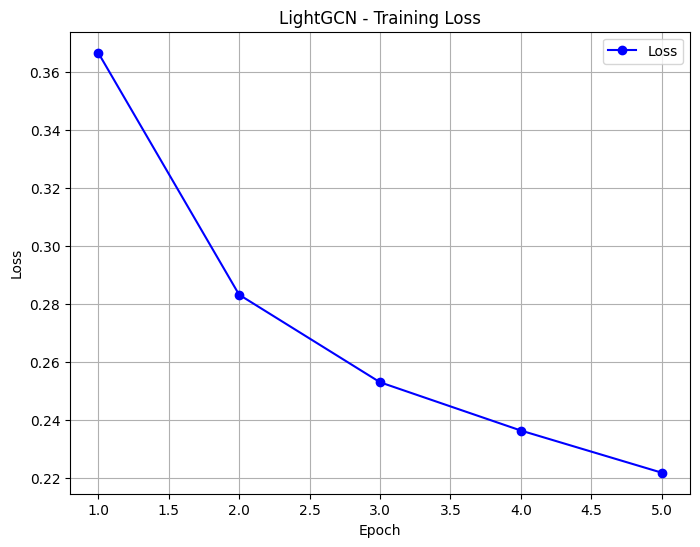

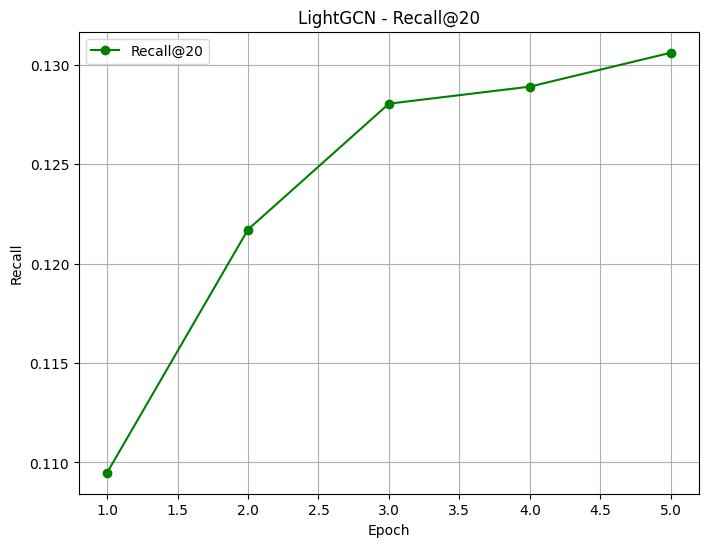

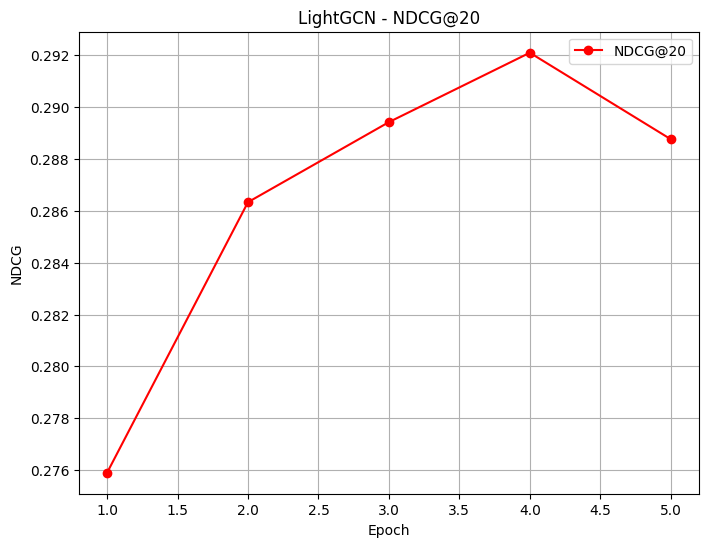


Evaluating on test data...

Evaluation Results (k=20):
  Recall@20:    0.133036
  NDCG@20:      0.298355

User and item embeddings saved.


In [ ]:
import json
import numpy as np
import scipy.sparse as sp
import tensorflow as tf
import random
from tensorflow.keras.utils import Progbar
import matplotlib.pyplot as plt
from collections import defaultdict

def load_mydataset(train_file, test_file, val_file):
    def read_json(path):
        with open(path, 'r') as f:
            return [set(x) for x in json.load(f)]

    train_list = read_json(train_file)
    test_list = read_json(test_file)
    val_list = read_json(val_file)

    # item set from training data
    train_items = {item for items in train_list for item in items}

    def filter_orphans(data_list, valid_items):
        # remove items not appear in train
        return [{item for item in items if item in valid_items} for items in data_list]

    test_list = filter_orphans(test_list, train_items)
    val_list = filter_orphans(val_list, train_items)

    n_users = len(train_list)
    n_items = max(train_items) + 1 if train_items else 0

    return train_list, test_list, val_list, n_users, n_items

def build_adjacency_matrix(train_data, n_users, n_items):
    # Create a bipartite adjacency matrix [0, R; R^T, 0].
    R_dok = sp.dok_matrix((n_users, n_items), dtype=np.float32)
    for u, items in enumerate(train_data):
        for i in items:
            R_dok[u, i] = 1.0
    R_csr = R_dok.tocsr()

    adj_size = n_users + n_items
    adj_dok = sp.dok_matrix((adj_size, adj_size), dtype=np.float32)
    # R in the upper-right block
    adj_dok[:n_users, n_users:] = R_csr
    # R^T in the lower-left block
    adj_dok[n_users:, :n_users] = R_csr.transpose()
    return adj_dok.tocsr()

def normalize_adj_sym(adj_mat):
    # symmetric normalization: D^-1/2 * A * D^-1/2.
    rowsum = np.array(adj_mat.sum(axis=1)).flatten() + 1e-9
    d_inv_sqrt = np.power(rowsum, -0.5)
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.0
    D_inv_sqrt = sp.diags(d_inv_sqrt)
    return D_inv_sqrt.dot(adj_mat).dot(D_inv_sqrt)

class LightGCNModel(tf.keras.Model):
    def __init__(self, n_users, n_items, adj_mat, n_layers=3, emb_dim=64, decay=1e-4, use_personalized_alpha=False):
        super().__init__()
        self.n_users = n_users
        self.n_items = n_items
        self.adj_mat = adj_mat  # TF SparseTensor
        self.n_layers = n_layers
        self.emb_dim = emb_dim
        self.decay = decay
        self.use_personalized_alpha = use_personalized_alpha

        initializer = tf.initializers.GlorotUniform()
        self.user_embedding = self.add_weight(
            name='user_embedding',
            shape=(n_users, emb_dim),
            initializer=initializer,
            trainable=True
        )
        self.item_embedding = self.add_weight(
            name='item_embedding',
            shape=(n_items, emb_dim),
            initializer=initializer,
            trainable=True
        )

        # learn personalized alpha across layers
        if use_personalized_alpha:
            self.alpha_mlp = tf.keras.Sequential([
                tf.keras.layers.Dense(n_layers + 1, activation='softmax')
            ])

    def call(self, embeddings):
        user_emb, item_emb = embeddings
        all_emb = tf.concat([user_emb, item_emb], axis=0)
        emb_list = [all_emb]

        # propagation layers
        for _ in range(self.n_layers):
            all_emb = tf.sparse.sparse_dense_matmul(self.adj_mat, all_emb)
            emb_list.append(all_emb)

        # combine embeddings from different layers
        if not self.use_personalized_alpha:
            # uniform average of all (K+1) layers
            alpha_k = 1.0 / (self.n_layers + 1)
            alpha_weights = [alpha_k] * (self.n_layers + 1)
            alpha_weights = tf.convert_to_tensor(alpha_weights, dtype=tf.float32)
            alpha_weights = tf.reshape(alpha_weights, (-1, 1, 1))
            stacked_emb = tf.stack(emb_list, axis=0)  # shape (K+1, n_users+n_items, emb_dim)
            combined_emb = tf.reduce_sum(stacked_emb * alpha_weights, axis=0)
        else:
            alpha = self.alpha_mlp(emb_list[0])  # or pass user context
            alpha = tf.expand_dims(alpha, axis=-1)
            stacked_emb = tf.stack(emb_list, axis=0)
            combined_emb = tf.reduce_sum(stacked_emb * alpha, axis=0)

        user_final, item_final = tf.split(combined_emb, [self.n_users, self.n_items], axis=0)
        return user_final, item_final

    def recommend(self, user_ids, k=10):
        updated_user_emb, updated_item_emb = self((self.user_embedding, self.item_embedding))
        user_vecs = tf.gather(updated_user_emb, user_ids)

        all_recs = []
        for idx, uid in enumerate(user_ids):
            u_vec = user_vecs[idx:idx + 1]
            scores = tf.matmul(u_vec, updated_item_emb, transpose_b=True)  # (1, n_items)
            scores_np = scores.numpy().flatten()
            idx_topk = np.argsort(scores_np)[::-1][:k]
            score_topk = scores_np[idx_topk]
            for item_id, sc in zip(idx_topk, score_topk):
                all_recs.append((int(uid), int(item_id), float(sc)))
        return all_recs

def sample_neg(pos_items, n_items, strategy='random'):
    if strategy == 'random':
        neg_item = random.randint(0, n_items - 1)
        while neg_item in pos_items:
            neg_item = random.randint(0, n_items - 1)
    return neg_item


def train_lightgcn(model, train_data, val_data, n_users, n_items, batch_size=1024, epochs=10, initial_lr=1e-2, k=20):

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=initial_lr,
        decay_steps=1000,
        decay_rate=0.96,
        staircase=True
    )
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    train_pairs = [(u, i) for u in range(n_users) for i in train_data[u]]
    steps_per_epoch = len(train_pairs) // batch_size + (len(train_pairs) % batch_size != 0)

    epoch_losses = []
    recall_scores = [] 
    ndcg_scores = [] 

    for epoch in range(1, epochs + 1):
        random.shuffle(train_pairs)
        progbar = Progbar(steps_per_epoch)

        epoch_loss = 0
        for step in range(steps_per_epoch):
            batch_slice = train_pairs[step * batch_size:(step + 1) * batch_size]
            users = [u for (u, _) in batch_slice]
            pos_items = [i for (_, i) in batch_slice]
            neg_items = [sample_neg(train_data[u], n_items) for (u, _) in batch_slice]

            users = np.array(users, dtype=np.int32)
            pos_items = np.array(pos_items, dtype=np.int32)
            neg_items = np.array(neg_items, dtype=np.int32)

            with tf.GradientTape() as tape:
                user_emb, item_emb = model((model.user_embedding, model.item_embedding))
                u_emb = tf.nn.embedding_lookup(user_emb, users)
                pos_emb = tf.nn.embedding_lookup(item_emb, pos_items)
                neg_emb = tf.nn.embedding_lookup(item_emb, neg_items)

                # BPR loss
                pos_scores = tf.reduce_sum(u_emb * pos_emb, axis=1)
                neg_scores = tf.reduce_sum(u_emb * neg_emb, axis=1)
                mf_loss = tf.reduce_mean(tf.nn.softplus(neg_scores - pos_scores))

                # L2 Regularization
                reg_loss = model.decay * (
                    tf.nn.l2_loss(u_emb) + tf.nn.l2_loss(pos_emb) + tf.nn.l2_loss(neg_emb)
                ) / batch_size

                loss = mf_loss + reg_loss

            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            epoch_loss += loss.numpy()
            progbar.add(1, values=[('loss', float(loss))])

        avg_epoch_loss = epoch_loss / steps_per_epoch
        epoch_losses.append(avg_epoch_loss)
        print(f"Epoch {epoch}/{epochs} completed. Average loss: {avg_epoch_loss:.6f}")

        val_users = [u for u in range(n_users) if len(val_data[u]) > 0]
        val_recs = model.recommend(val_users, k=k)
        epoch_recall = recall_at_k(val_recs, val_data, k=k)
        epoch_ndcg = ndcg(val_recs, val_data, k=k)

        recall_scores.append(epoch_recall)
        ndcg_scores.append(epoch_ndcg)
        print(f"Epoch {epoch}: Recall@{k}: {epoch_recall:.6f}, NDCG@{k}: {epoch_ndcg:.6f}")

    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o', linestyle='-', color='b', label="Loss")
    plt.title("LightGCN - Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(recall_scores) + 1), recall_scores, marker='o', linestyle='-', color='g', label=f"Recall@{k}")
    plt.title(f"LightGCN - Recall@{k}")
    plt.xlabel("Epoch")
    plt.ylabel("Recall")
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(ndcg_scores) + 1), ndcg_scores, marker='o', linestyle='-', color='r', label=f"NDCG@{k}")
    plt.title(f"LightGCN - NDCG@{k}")
    plt.xlabel("Epoch")
    plt.ylabel("NDCG")
    plt.grid(True)
    plt.legend()
    plt.show()

    return epoch_losses, recall_scores, ndcg_scores


def recall_at_k(recs, test_data, k=10):
    user_recs = defaultdict(list)
    for (u, i, s) in recs:
        user_recs[u].append(i)
    recalls = []
    for u, items_pred in user_recs.items():
        if len(test_data[u]) == 0:
            continue
        if k > 0:
            items_pred = items_pred[:k]
        gt = test_data[u]
        num_hit = len(set(items_pred).intersection(gt))
        recalls.append(num_hit / float(len(gt)))
    return np.mean(recalls) if recalls else 0.0

def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(r / np.log2(np.arange(2, r.size + 2)))
    return 0.

def ndcg_at_k(recommended, ground_truth, k=10):
    rel = [1 if i in ground_truth else 0 for i in recommended[:k]]
    ideal_rel = sorted(rel, reverse=True)
    dcg = dcg_at_k(rel, k)
    idcg = dcg_at_k(ideal_rel, k)
    return (dcg / idcg) if idcg > 0 else 0.0

def ndcg(recs, test_data, k=10):
    user_recs = defaultdict(list)
    for (u, i, s) in recs:
        user_recs[u].append(i)
    ndcgs = []
    for u, items_pred in user_recs.items():
        gt = test_data[u]
        if len(gt) == 0:
            continue
        ndcgs.append(ndcg_at_k(items_pred, gt, k))
    return np.mean(ndcgs) if ndcgs else 0.0


def evaluate_lightgcn(model, users, test_data, ks=[5, 10, 20], batch_size=2000):
    all_recs = []
    idx_start = 0
    max_k = max(ks)
    while idx_start < len(users):
        idx_end = min(idx_start + batch_size, len(users))
        user_batch = users[idx_start:idx_end]
        recs_chunk = model.recommend(user_batch, k=max_k)
        all_recs.extend(recs_chunk)
        idx_start = idx_end

    results = {}
    for k in ks:
        rec = recall_at_k(all_recs, test_data, k=k)
        ndcg_ = ndcg(all_recs, test_data, k=k)
        results[k] = (rec, ndcg_)
        print(f"\nEvaluation Results (k={k}):")
        print(f"  Recall@{k}:    {rec:.6f}")
        print(f"  NDCG@{k}:      {ndcg_:.6f}")

    return results


train_file = '/kaggle/input/dataset-movielens/train_data.json'
test_file = '/kaggle/input/dataset-movielens/test_data.json'
val_file = '/kaggle/input/dataset-movielens/validation_data.json'

train_data, test_data, val_data, n_users, n_items = load_mydataset(
    train_file, test_file, val_file
)
print(f"Number of Users: {n_users}, Number of Items: {n_items}")

adj_csr = build_adjacency_matrix(train_data, n_users, n_items)
norm_adj_csr = normalize_adj_sym(adj_csr)

# convert to TensorFlow SparseTensor
coo = norm_adj_csr.tocoo().astype(np.float32)
indices = np.vstack((coo.row, coo.col)).transpose()
A_tilde = tf.sparse.SparseTensor(indices=indices, values=coo.data, dense_shape=coo.shape)
A_tilde = tf.sparse.reorder(A_tilde)

N_LAYERS = 4
EMBED_DIM = 128
DECAY = 1e-5
INITIAL_LR = 1e-2
EPOCHS = 5
BATCH_SIZE = 1024

model = LightGCNModel(
    n_users=n_users,
    n_items=n_items,
    adj_mat=A_tilde,
    n_layers=N_LAYERS,
    emb_dim=EMBED_DIM,
    decay=DECAY,
    use_personalized_alpha=False
)

print("\nStarting LightGCN training...")
train_lightgcn(
    model=model,
    train_data=train_data,
    val_data=val_data,
    n_users=n_users,
    n_items=n_items,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    initial_lr=INITIAL_LR,
    k=20
)

print("\nEvaluating on test data...")
test_users = [u for u in range(n_users) if len(test_data[u]) > 0]
_ = evaluate_lightgcn(model, test_users, test_data, ks=[20])

user_emb, item_emb = model((model.user_embedding, model.item_embedding))
np.save("lightgcn_user_embeddings.npy", user_emb.numpy())
np.save("lightgcn_item_embeddings.npy", item_emb.numpy())
print("\nUser and item embeddings saved.")

# Improve model

### Method 1

Number of Users: 6022, Number of Items: 3043

Starting LightGCN training...
778/778 ━━━━━━━━━━━━━━━━━━━━ 89s 114ms/step - loss: 0.3880
Epoch 1/15 completed. Average loss: 0.388022
778/778 ━━━━━━━━━━━━━━━━━━━━ 89s 114ms/step - loss: 0.3067
Epoch 2/15 completed. Average loss: 0.306721
778/778 ━━━━━━━━━━━━━━━━━━━━ 89s 114ms/step - loss: 0.2784
Epoch 3/15 completed. Average loss: 0.278429
778/778 ━━━━━━━━━━━━━━━━━━━━ 89s 114ms/step - loss: 0.2635
Epoch 4/15 completed. Average loss: 0.263534
778/778 ━━━━━━━━━━━━━━━━━━━━ 89s 114ms/step - loss: 0.2510
Epoch 5/15 completed. Average loss: 0.250964
778/778 ━━━━━━━━━━━━━━━━━━━━ 89s 114ms/step - loss: 0.2401
Epoch 6/15 completed. Average loss: 0.240144
778/778 ━━━━━━━━━━━━━━━━━━━━ 89s 114ms/step - loss: 0.2326
Epoch 7/15 completed. Average loss: 0.232648
778/778 ━━━━━━━━━━━━━━━━━━━━ 89s 114ms/step - loss: 0.2268
Epoch 8/15 completed. Average loss: 0.226791
778/778 ━━━━━━━━━━━━━━━━━━━━ 89s 114ms/step - loss: 0.2208
Epoch 9/15 completed. Average los

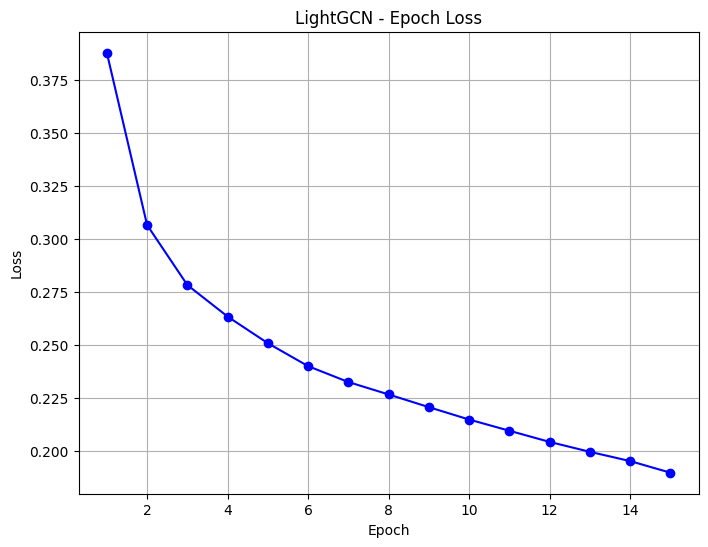


Evaluating on test data...

Evaluation Results (k=20):
  Recall@20:    0.150926
  NDCG@20:      0.311871


In [ ]:
import json
import numpy as np
import scipy.sparse as sp
import tensorflow as tf
import random
from tensorflow.keras.utils import Progbar
import matplotlib.pyplot as plt
from collections import defaultdict

def load_mydataset(train_file, test_file, val_file):
    def read_json(path):
        with open(path, 'r') as f:
            return [set(x) for x in json.load(f)]

    train_list = read_json(train_file)
    test_list = read_json(test_file)
    val_list = read_json(val_file)

    train_items = {item for items in train_list for item in items}

    def filter_orphans(data_list, valid_items):
        # remove items that never appear in train
        return [{item for item in items if item in valid_items} for items in data_list]

    test_list = filter_orphans(test_list, train_items)
    val_list = filter_orphans(val_list, train_items)

    n_users = len(train_list)
    n_items = max(train_items) + 1 if train_items else 0

    return train_list, test_list, val_list, n_users, n_items

def build_adjacency_matrix(train_data, n_users, n_items):
    # Create a bipartite adjacency matrix [0, R; R^T, 0].
    R_dok = sp.dok_matrix((n_users, n_items), dtype=np.float32)
    for u, items in enumerate(train_data):
        for i in items:
            R_dok[u, i] = 1.0
    R_csr = R_dok.tocsr()

    adj_size = n_users + n_items
    adj_dok = sp.dok_matrix((adj_size, adj_size), dtype=np.float32)
    # R in the upper-right block
    adj_dok[:n_users, n_users:] = R_csr
    # R^T in the lower-left block
    adj_dok[n_users:, :n_users] = R_csr.transpose()
    return adj_dok.tocsr()


def normalize_adj_sym(adj_mat):
    # symmetric normalization: D^-1/2 * A * D^-1/2.
    rowsum = np.array(adj_mat.sum(axis=1)).flatten() + 1e-9
    d_inv_sqrt = np.power(rowsum, -0.5)
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.0
    D_inv_sqrt = sp.diags(d_inv_sqrt)
    return D_inv_sqrt.dot(adj_mat).dot(D_inv_sqrt)

def identify_influential_nodes(train_data, n_users, n_items, threshold=10):
    item_degrees = defaultdict(int)
    for items in train_data:
        for item in items:
            item_degrees[item] += 1

    # item_degree > thereshold -> influential/popular
    popular_items = {item for item, degree in item_degrees.items() if degree > threshold}
    return popular_items


class LightGCNModel(tf.keras.Model):
    def __init__(self, n_users, n_items, adj_mat, n_layers=3, emb_dim=64, decay=1e-4, use_personalized_alpha=False):
        super(LightGCNModel, self).__init__()
        self.n_users = n_users
        self.n_items = n_items
        self.adj_mat = adj_mat  # TF SparseTensor
        self.n_layers = n_layers
        self.emb_dim = emb_dim
        self.decay = decay
        self.use_personalized_alpha = use_personalized_alpha

        initializer = tf.initializers.GlorotUniform()
        self.user_embedding = self.add_weight(
            name='user_embedding',
            shape=(n_users, emb_dim),
            initializer=initializer,
            trainable=True
        )
        self.item_embedding = self.add_weight(
            name='item_embedding',
            shape=(n_items, emb_dim),
            initializer=initializer,
            trainable=True
        )

        if use_personalized_alpha:
            self.alpha_mlp = tf.keras.Sequential([
                tf.keras.layers.Dense(n_layers + 1, activation='softmax')
            ])


    def remove_popularity_effect(self, all_emb, popular_items, n_users, reduction_factor=0.5):
        item_emb = all_emb[n_users:] 
        user_emb = all_emb[:n_users]

        # mask for popular items
        popular_mask = np.zeros(item_emb.shape[0], dtype=np.float32)
        for item in popular_items:
            popular_mask[item] = 1.0

        popular_mask = tf.convert_to_tensor(popular_mask, dtype=tf.float32)
        popular_mask = tf.reshape(popular_mask, (-1, 1))

        # mean embedding of popular items
        mean_popular_emb = tf.reduce_mean(item_emb * popular_mask, axis=0, keepdims=True)

        # reduce the influence of popular items
        corrected_item_emb = item_emb - (reduction_factor * mean_popular_emb * popular_mask)
        corrected_user_emb = user_emb

        return tf.concat([corrected_user_emb, corrected_item_emb], axis=0)

    def call(self, embeddings, popular_items=None):
        user_emb, item_emb = embeddings
        all_emb = tf.concat([user_emb, item_emb], axis=0)
        emb_list = [all_emb]

        # propagation layers + popularity adjustment
        for _ in range(self.n_layers):
            all_emb = tf.sparse.sparse_dense_matmul(self.adj_mat, all_emb)

            if popular_items is not None:
                all_emb = self.remove_popularity_effect(all_emb, popular_items, self.n_users)

            emb_list.append(all_emb)

        # combine embeddings from different layers
        alpha_k = 1.0 / (self.n_layers + 1)
        alpha_weights = [alpha_k] * (self.n_layers + 1)
        alpha_weights = tf.convert_to_tensor(alpha_weights, dtype=tf.float32)
        alpha_weights = tf.reshape(alpha_weights, (-1, 1, 1))
        stacked_emb = tf.stack(emb_list, axis=0)  # shape (K+1, n_users+n_items, emb_dim)
        combined_emb = tf.reduce_sum(stacked_emb * alpha_weights, axis=0)

        user_final, item_final = tf.split(combined_emb, [self.n_users, self.n_items], axis=0)
        return user_final, item_final


    def recommend(self, user_ids, k=10):
        updated_user_emb, updated_item_emb = self((self.user_embedding, self.item_embedding))
        user_vecs = tf.gather(updated_user_emb, user_ids)

        all_recs = []
        for idx, uid in enumerate(user_ids):
            u_vec = user_vecs[idx:idx + 1]
            scores = tf.matmul(u_vec, updated_item_emb, transpose_b=True)  # (1, n_items)
            scores_np = scores.numpy().flatten()
            idx_topk = np.argsort(scores_np)[::-1][:k]
            score_topk = scores_np[idx_topk]
            for item_id, sc in zip(idx_topk, score_topk):
                all_recs.append((int(uid), int(item_id), float(sc)))
        return all_recs


def sample_neg(pos_items, n_items, strategy='random'):
    if strategy == 'random':
        neg_item = random.randint(0, n_items - 1)
        while neg_item in pos_items:
            neg_item = random.randint(0, n_items - 1)
    return neg_item


def train_lightgcn(model, train_data, n_users, n_items, batch_size=1024, epochs=10, initial_lr=1e-2, popular_items=None):
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=initial_lr,
        decay_steps=1000,
        decay_rate=0.96,
        staircase=True
    )
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    # (user, item) pairs from train_data
    train_pairs = [(u, i) for u in range(n_users) for i in train_data[u]]
    steps_per_epoch = len(train_pairs) // batch_size + (len(train_pairs) % batch_size != 0)

    epoch_losses = []
    for epoch in range(1, epochs + 1):
        random.shuffle(train_pairs)
        progbar = Progbar(steps_per_epoch)

        epoch_loss = 0
        for step in range(steps_per_epoch):
            batch_slice = train_pairs[step * batch_size:(step + 1) * batch_size]
            users = [u for (u, _) in batch_slice]
            pos_items = [i for (_, i) in batch_slice]
            neg_items = [sample_neg(train_data[u], n_items) for (u, _) in batch_slice]

            users = np.array(users, dtype=np.int32)
            pos_items = np.array(pos_items, dtype=np.int32)
            neg_items = np.array(neg_items, dtype=np.int32)

            with tf.GradientTape() as tape:
                user_emb, item_emb = model(
                    (model.user_embedding, model.item_embedding),
                    popular_items=popular_items  # Pass popular items
                )
                u_emb = tf.nn.embedding_lookup(user_emb, users)
                pos_emb = tf.nn.embedding_lookup(item_emb, pos_items)
                neg_emb = tf.nn.embedding_lookup(item_emb, neg_items)

                # BPR loss: mean( softplus(neg_score - pos_score) )
                pos_scores = tf.reduce_sum(u_emb * pos_emb, axis=1)
                neg_scores = tf.reduce_sum(u_emb * neg_emb, axis=1)
                mf_loss = tf.reduce_mean(tf.nn.softplus(neg_scores - pos_scores))

                # L2 Regularization
                reg_loss = model.decay * (
                    tf.nn.l2_loss(u_emb) + tf.nn.l2_loss(pos_emb) + tf.nn.l2_loss(neg_emb)
                ) / batch_size

                loss = mf_loss + reg_loss

            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            epoch_loss += loss.numpy()
            progbar.add(1, values=[('loss', float(loss))])

        avg_epoch_loss = epoch_loss / steps_per_epoch
        epoch_losses.append(avg_epoch_loss)
        print(f"Epoch {epoch}/{epochs} completed. Average loss: {avg_epoch_loss:.6f}")

    # Plot epoch losses
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o', linestyle='-', color='b')
    plt.title("LightGCN - Epoch Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

def recall_at_k(recs, test_data, k=10):
    user_recs = defaultdict(list)
    for (u, i, s) in recs:
        user_recs[u].append(i)
    recalls = []
    for u, items_pred in user_recs.items():
        if len(test_data[u]) == 0:
            continue
        if k > 0:
            items_pred = items_pred[:k]
        gt = test_data[u]
        num_hit = len(set(items_pred).intersection(gt))
        recalls.append(num_hit / float(len(gt)))
    return np.mean(recalls) if recalls else 0.0

def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(r / np.log2(np.arange(2, r.size + 2)))
    return 0.

def ndcg_at_k(recommended, ground_truth, k=10):
    rel = [1 if i in ground_truth else 0 for i in recommended[:k]]
    ideal_rel = sorted(rel, reverse=True)
    dcg = dcg_at_k(rel, k)
    idcg = dcg_at_k(ideal_rel, k)
    return (dcg / idcg) if idcg > 0 else 0.0

def ndcg(recs, test_data, k=10):
    user_recs = defaultdict(list)
    for (u, i, s) in recs:
        user_recs[u].append(i)
    ndcgs = []
    for u, items_pred in user_recs.items():
        gt = test_data[u]
        if len(gt) == 0:
            continue
        ndcgs.append(ndcg_at_k(items_pred, gt, k))
    return np.mean(ndcgs) if ndcgs else 0.0


def evaluate_lightgcn(model, users, test_data, ks=[5, 10, 20], batch_size=2000):
    all_recs = []
    idx_start = 0
    max_k = max(ks)
    while idx_start < len(users):
        idx_end = min(idx_start + batch_size, len(users))
        user_batch = users[idx_start:idx_end]
        recs_chunk = model.recommend(user_batch, k=max_k)
        all_recs.extend(recs_chunk)
        idx_start = idx_end

    results = {}
    for k in ks:
        rec = recall_at_k(all_recs, test_data, k=k)
        ndcg_ = ndcg(all_recs, test_data, k=k)
        results[k] = (rec, ndcg_)
        print(f"\nEvaluation Results (k={k}):")
        print(f"  Recall@{k}:    {rec:.6f}")
        print(f"  NDCG@{k}:      {ndcg_:.6f}")

    return results



train_file = '/kaggle/input/dataset-movielens/train_data.json'
test_file = '/kaggle/input/dataset-movielens/test_data.json'
val_file = '/kaggle/input/dataset-movielens/validation_data.json'

train_data, test_data, val_data, n_users, n_items = load_mydataset(
    train_file, test_file, val_file
)
print(f"Number of Users: {n_users}, Number of Items: {n_items}")

adj_csr = build_adjacency_matrix(train_data, n_users, n_items)
norm_adj_csr = normalize_adj_sym(adj_csr)

# convert to TensorFlow SparseTensor
coo = norm_adj_csr.tocoo().astype(np.float32)
indices = np.vstack((coo.row, coo.col)).transpose()
A_tilde = tf.sparse.SparseTensor(indices=indices, values=coo.data, dense_shape=coo.shape)
A_tilde = tf.sparse.reorder(A_tilde)

N_LAYERS = 4
EMBED_DIM = 64
DECAY = 1e-3
INITIAL_LR = 1e-2
EPOCHS = 15
BATCH_SIZE = 1024

model = LightGCNModel(
    n_users=n_users,
    n_items=n_items,
    adj_mat=A_tilde,
    n_layers=N_LAYERS,
    emb_dim=EMBED_DIM,
    decay=DECAY,
    use_personalized_alpha=False
)

print("\nStarting LightGCN training...")
popular_items = identify_influential_nodes(train_data, n_users, n_items, threshold=10)

train_lightgcn(
    model=model,
    train_data=train_data,
    n_users=n_users,
    n_items=n_items,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    initial_lr=INITIAL_LR,
    popular_items=popular_items
)

print("\nEvaluating on test data...")
test_users = [u for u in range(n_users) if len(test_data[u]) > 0]
_ = evaluate_lightgcn(model, test_users, test_data, ks=[20])


### Method 2

Number of Users: 6022, Number of Items: 3043

Starting LightGCN training...
778/778 ━━━━━━━━━━━━━━━━━━━━ 84s 108ms/step - loss: 0.3999
Epoch 1/10 completed. Average loss: 0.399937
778/778 ━━━━━━━━━━━━━━━━━━━━ 85s 109ms/step - loss: 0.3156
Epoch 2/10 completed. Average loss: 0.315563
778/778 ━━━━━━━━━━━━━━━━━━━━ 86s 110ms/step - loss: 0.2839
Epoch 3/10 completed. Average loss: 0.283942
778/778 ━━━━━━━━━━━━━━━━━━━━ 86s 110ms/step - loss: 0.2651
Epoch 4/10 completed. Average loss: 0.265074
778/778 ━━━━━━━━━━━━━━━━━━━━ 86s 110ms/step - loss: 0.2535
Epoch 5/10 completed. Average loss: 0.253520
778/778 ━━━━━━━━━━━━━━━━━━━━ 86s 110ms/step - loss: 0.2445
Epoch 6/10 completed. Average loss: 0.244530
778/778 ━━━━━━━━━━━━━━━━━━━━ 86s 111ms/step - loss: 0.2372
Epoch 7/10 completed. Average loss: 0.237192
778/778 ━━━━━━━━━━━━━━━━━━━━ 86s 110ms/step - loss: 0.2312
Epoch 8/10 completed. Average loss: 0.231167
778/778 ━━━━━━━━━━━━━━━━━━━━ 85s 110ms/step - loss: 0.2261
Epoch 9/10 completed. Average los

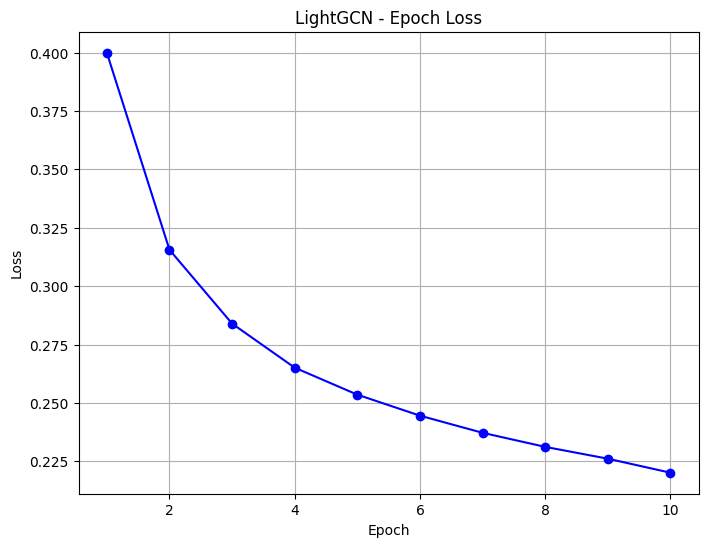


Evaluating on test data...

Evaluation Results (k=20):
  Recall@20:    0.133829
  NDCG@20:      0.300697


In [ ]:
import json
import numpy as np
import scipy.sparse as sp
import tensorflow as tf
import random
from tensorflow.keras.utils import Progbar
import matplotlib.pyplot as plt
from collections import defaultdict

def load_mydataset(train_file, test_file, val_file):
    def read_json(path):
        with open(path, 'r') as f:
            return [set(x) for x in json.load(f)]

    train_list = read_json(train_file)
    test_list = read_json(test_file)
    val_list = read_json(val_file)

    train_items = {item for items in train_list for item in items}

    def filter_orphans(data_list, valid_items):
        # remove items not appear in train set
        return [{item for item in items if item in valid_items} for items in data_list]

    test_list = filter_orphans(test_list, train_items)
    val_list = filter_orphans(val_list, train_items)

    n_users = len(train_list)
    n_items = max(train_items) + 1 if train_items else 0

    return train_list, test_list, val_list, n_users, n_items

def build_adjacency_matrix(train_data, n_users, n_items):
    R_dok = sp.dok_matrix((n_users, n_items), dtype=np.float32)
    for u, items in enumerate(train_data):
        for i in items:
            R_dok[u, i] = 1.0
    R_csr = R_dok.tocsr()

    adj_size = n_users + n_items
    adj_dok = sp.dok_matrix((adj_size, adj_size), dtype=np.float32)
    # R in the upper-right block
    adj_dok[:n_users, n_users:] = R_csr
    # R^T in the lower-left block
    adj_dok[n_users:, :n_users] = R_csr.transpose()
    return adj_dok.tocsr()


def normalize_adj_sym(adj_mat):
    # symmetric normalization: D^-1/2 * A * D^-1/2.
    rowsum = np.array(adj_mat.sum(axis=1)).flatten() + 1e-9
    d_inv_sqrt = np.power(rowsum, -0.5)
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.0
    D_inv_sqrt = sp.diags(d_inv_sqrt)
    return D_inv_sqrt.dot(adj_mat).dot(D_inv_sqrt)

class LightGCNModel(tf.keras.Model):
    def __init__(self, n_users, n_items, adj_mat, n_layers=3, emb_dim=64, decay=1e-4, use_personalized_alpha=False):
        super().__init__()
        self.n_users = n_users
        self.n_items = n_items
        self.adj_mat = adj_mat  # TF SparseTensor
        self.n_layers = n_layers
        self.emb_dim = emb_dim
        self.decay = decay
        self.use_personalized_alpha = use_personalized_alpha

        initializer = tf.initializers.GlorotUniform()
        self.user_embedding = self.add_weight(
            name='user_embedding',
            shape=(n_users, emb_dim),
            initializer=initializer,
            trainable=True
        )
        self.item_embedding = self.add_weight(
            name='item_embedding',
            shape=(n_items, emb_dim),
            initializer=initializer,
            trainable=True
        )

        if use_personalized_alpha:
            self.alpha_mlp = tf.keras.Sequential([
                tf.keras.layers.Dense(n_layers + 1, activation='softmax')
            ])
        
        # node attribute prediction (auxiliary task)
        self.attribute_predictor = tf.keras.layers.Dense(emb_dim, activation='relu', name="attribute_predictor")


    def call(self, embeddings, mask_prob=0.2):
        user_emb, item_emb = embeddings
        all_emb = tf.concat([user_emb, item_emb], axis=0)
        emb_list = [all_emb]
    
        # propagation layers
        for _ in range(self.n_layers):
            all_emb = tf.sparse.sparse_dense_matmul(self.adj_mat, all_emb)
            emb_list.append(all_emb)
    
        # combine embeddings from different layers
        if not self.use_personalized_alpha:
            alpha_k = 1.0 / (self.n_layers + 1)
            alpha_weights = [alpha_k] * (self.n_layers + 1)
            alpha_weights = tf.convert_to_tensor(alpha_weights, dtype=tf.float32)
            alpha_weights = tf.reshape(alpha_weights, (-1, 1, 1))
            stacked_emb = tf.stack(emb_list, axis=0)
            combined_emb = tf.reduce_sum(stacked_emb * alpha_weights, axis=0)
        else:
            alpha = self.alpha_mlp(emb_list[0])
            alpha = tf.expand_dims(alpha, axis=-1)
            stacked_emb = tf.stack(emb_list, axis=0)
            combined_emb = tf.reduce_sum(stacked_emb * alpha, axis=0)
    
        user_final, item_final = tf.split(combined_emb, [self.n_users, self.n_items], axis=0)
    
        # node attribute prediction
        masked_user_emb, mask = mask_embeddings(user_final, mask_prob)
        predicted_attributes = self.attribute_predictor(masked_user_emb)
        return user_final, item_final, masked_user_emb, predicted_attributes, mask


    def recommend(self, user_ids, k=10):
        user_final, item_final, _, _, _ = self((self.user_embedding, self.item_embedding))
        user_vecs = tf.gather(user_final, user_ids)
    
        all_recs = []
        for idx, uid in enumerate(user_ids):
            u_vec = user_vecs[idx:idx + 1]
            scores = tf.matmul(u_vec, item_final, transpose_b=True)  # (1, n_items)
            scores_np = scores.numpy().flatten()
            idx_topk = np.argsort(scores_np)[::-1][:k]
            score_topk = scores_np[idx_topk]
            for item_id, sc in zip(idx_topk, score_topk):
                all_recs.append((int(uid), int(item_id), float(sc)))
        return all_recs

def mask_embeddings(embeddings, mask_prob=0.2):
    mask = tf.cast(tf.random.uniform(embeddings.shape) > mask_prob, tf.float32)
    masked_embeddings = embeddings * mask
    return masked_embeddings, mask


def sample_neg(pos_items, n_items, strategy='random'):
    if strategy == 'random':
        neg_item = random.randint(0, n_items - 1)
        while neg_item in pos_items:
            neg_item = random.randint(0, n_items - 1)
    return neg_item


def train_lightgcn(model, train_data, n_users, n_items, batch_size=1024, epochs=10, initial_lr=1e-2):
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=initial_lr,
        decay_steps=1000,
        decay_rate=0.96,
        staircase=True
    )
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    # (user, item) pairs from train_data
    train_pairs = [(u, i) for u in range(n_users) for i in train_data[u]]
    steps_per_epoch = len(train_pairs) // batch_size + (len(train_pairs) % batch_size != 0)

    epoch_losses = []
    for epoch in range(1, epochs + 1):
        random.shuffle(train_pairs)
        progbar = Progbar(steps_per_epoch)

        epoch_loss = 0
        for step in range(steps_per_epoch):
            batch_slice = train_pairs[step * batch_size:(step + 1) * batch_size]
            users = [u for (u, _) in batch_slice]
            pos_items = [i for (_, i) in batch_slice]
            neg_items = [sample_neg(train_data[u], n_items) for (u, _) in batch_slice]

            users = np.array(users, dtype=np.int32)
            pos_items = np.array(pos_items, dtype=np.int32)
            neg_items = np.array(neg_items, dtype=np.int32)

            with tf.GradientTape() as tape:
                user_emb, item_emb, masked_user_emb, predicted_attributes, mask = model(
                    (model.user_embedding, model.item_embedding)
                )
                u_emb = tf.nn.embedding_lookup(user_emb, users)
                pos_emb = tf.nn.embedding_lookup(item_emb, pos_items)
                neg_emb = tf.nn.embedding_lookup(item_emb, neg_items)
            
                # BPR loss: mean( softplus(neg_score - pos_score) )
                pos_scores = tf.reduce_sum(u_emb * pos_emb, axis=1)
                neg_scores = tf.reduce_sum(u_emb * neg_emb, axis=1)
                mf_loss = tf.reduce_mean(tf.nn.softplus(neg_scores - pos_scores))
            
                # node attribute prediction loss
                attribute_loss = tf.reduce_mean(tf.square(masked_user_emb - predicted_attributes) * mask)
            
                # L2 Regularization
                reg_loss = model.decay * (
                    tf.nn.l2_loss(u_emb) + tf.nn.l2_loss(pos_emb) + tf.nn.l2_loss(neg_emb)
                ) / batch_size
            
                # total loss
                loss = mf_loss + reg_loss + 0.1 * attribute_loss  # Weighted auxiliary loss


            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            epoch_loss += loss.numpy()
            progbar.add(1, values=[('loss', float(loss))])

        avg_epoch_loss = epoch_loss / steps_per_epoch
        epoch_losses.append(avg_epoch_loss)
        print(f"Epoch {epoch}/{epochs} completed. Average loss: {avg_epoch_loss:.6f}")

    # Plot epoch losses
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o', linestyle='-', color='b')
    plt.title("LightGCN - Epoch Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

def recall_at_k(recs, test_data, k=10):
    user_recs = defaultdict(list)
    for (u, i, s) in recs:
        user_recs[u].append(i)
    recalls = []
    for u, items_pred in user_recs.items():
        if len(test_data[u]) == 0:
            continue
        if k > 0:
            items_pred = items_pred[:k]
        gt = test_data[u]
        num_hit = len(set(items_pred).intersection(gt))
        recalls.append(num_hit / float(len(gt)))
    return np.mean(recalls) if recalls else 0.0

def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(r / np.log2(np.arange(2, r.size + 2)))
    return 0.

def ndcg_at_k(recommended, ground_truth, k=10):
    rel = [1 if i in ground_truth else 0 for i in recommended[:k]]
    ideal_rel = sorted(rel, reverse=True)
    dcg = dcg_at_k(rel, k)
    idcg = dcg_at_k(ideal_rel, k)
    return (dcg / idcg) if idcg > 0 else 0.0

def ndcg(recs, test_data, k=10):
    user_recs = defaultdict(list)
    for (u, i, s) in recs:
        user_recs[u].append(i)
    ndcgs = []
    for u, items_pred in user_recs.items():
        gt = test_data[u]
        if len(gt) == 0:
            continue
        ndcgs.append(ndcg_at_k(items_pred, gt, k))
    return np.mean(ndcgs) if ndcgs else 0.0


def evaluate_lightgcn(model, users, test_data, ks=[5, 10, 20], batch_size=2000):
    all_recs = []
    idx_start = 0
    max_k = max(ks)
    while idx_start < len(users):
        idx_end = min(idx_start + batch_size, len(users))
        user_batch = users[idx_start:idx_end]
        recs_chunk = model.recommend(user_batch, k=max_k)
        all_recs.extend(recs_chunk)
        idx_start = idx_end

    results = {}
    for k in ks:
        rec = recall_at_k(all_recs, test_data, k=k)
        ndcg_ = ndcg(all_recs, test_data, k=k)
        results[k] = (rec, ndcg_)
        print(f"\nEvaluation Results (k={k}):")
        print(f"  Recall@{k}:    {rec:.6f}")
        print(f"  NDCG@{k}:      {ndcg_:.6f}")

    return results

train_file = '/kaggle/input/dataset-movielens/train_data.json'
test_file = '/kaggle/input/dataset-movielens/test_data.json'
val_file = '/kaggle/input/dataset-movielens/validation_data.json'

train_data, test_data, val_data, n_users, n_items = load_mydataset(
    train_file, test_file, val_file
)
print(f"Number of Users: {n_users}, Number of Items: {n_items}")

adj_csr = build_adjacency_matrix(train_data, n_users, n_items)
norm_adj_csr = normalize_adj_sym(adj_csr)

# convert to TensorFlow SparseTensor
coo = norm_adj_csr.tocoo().astype(np.float32)
indices = np.vstack((coo.row, coo.col)).transpose()
A_tilde = tf.sparse.SparseTensor(indices=indices, values=coo.data, dense_shape=coo.shape)
A_tilde = tf.sparse.reorder(A_tilde)

N_LAYERS = 4
EMBED_DIM = 64
DECAY = 1e-3
INITIAL_LR = 1e-2
EPOCHS = 10
BATCH_SIZE = 1024

model = LightGCNModel(
    n_users=n_users,
    n_items=n_items,
    adj_mat=A_tilde,
    n_layers=N_LAYERS,
    emb_dim=EMBED_DIM,
    decay=DECAY,
    use_personalized_alpha=False
)

print("\nStarting LightGCN training...")
train_lightgcn(
    model=model,
    train_data=train_data,
    n_users=n_users,
    n_items=n_items,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    initial_lr=INITIAL_LR
)

print("\nEvaluating on test data...")
test_users = [u for u in range(n_users) if len(test_data[u]) > 0]
_ = evaluate_lightgcn(model, test_users, test_data, ks=[20])

### Method 3

Number of Users: 6022, Number of Items: 3043

Starting LightGCN training...
778/778 ━━━━━━━━━━━━━━━━━━━━ 105s 133ms/step - loss: 0.4135
Epoch 1/10 - Avg loss: 0.413452
  [Val] Recall@20: 0.0927  NDCG@20: 0.2462
778/778 ━━━━━━━━━━━━━━━━━━━━ 103s 133ms/step - loss: 0.3303
Epoch 2/10 - Avg loss: 0.330315
  [Val] Recall@20: 0.1094  NDCG@20: 0.2716
778/778 ━━━━━━━━━━━━━━━━━━━━ 103s 133ms/step - loss: 0.2986
Epoch 3/10 - Avg loss: 0.298580
  [Val] Recall@20: 0.1173  NDCG@20: 0.2807
778/778 ━━━━━━━━━━━━━━━━━━━━ 104s 133ms/step - loss: 0.2818
Epoch 4/10 - Avg loss: 0.281760
  [Val] Recall@20: 0.1213  NDCG@20: 0.2885
778/778 ━━━━━━━━━━━━━━━━━━━━ 104s 133ms/step - loss: 0.2692
Epoch 5/10 - Avg loss: 0.269213
  [Val] Recall@20: 0.1235  NDCG@20: 0.2876
778/778 ━━━━━━━━━━━━━━━━━━━━ 103s 133ms/step - loss: 0.2596
Epoch 6/10 - Avg loss: 0.259623
  [Val] Recall@20: 0.1274  NDCG@20: 0.2921
778/778 ━━━━━━━━━━━━━━━━━━━━ 103s 133ms/step - loss: 0.2508
Epoch 7/10 - Avg loss: 0.250794
  [Val] Recall@20: 0.1

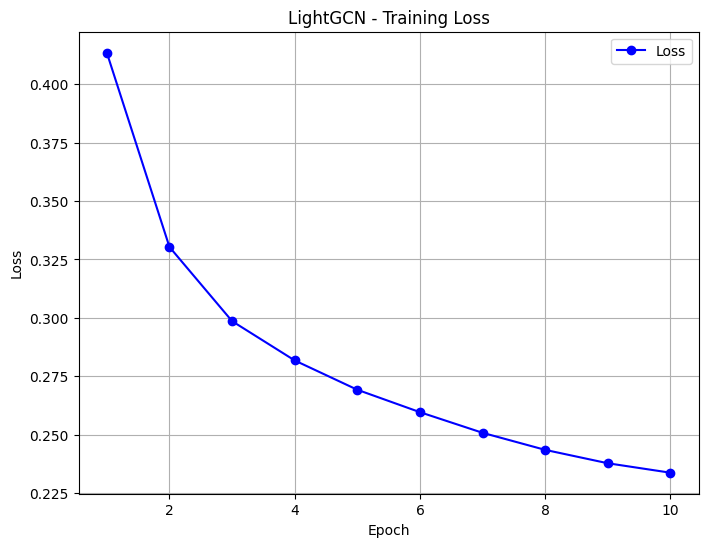

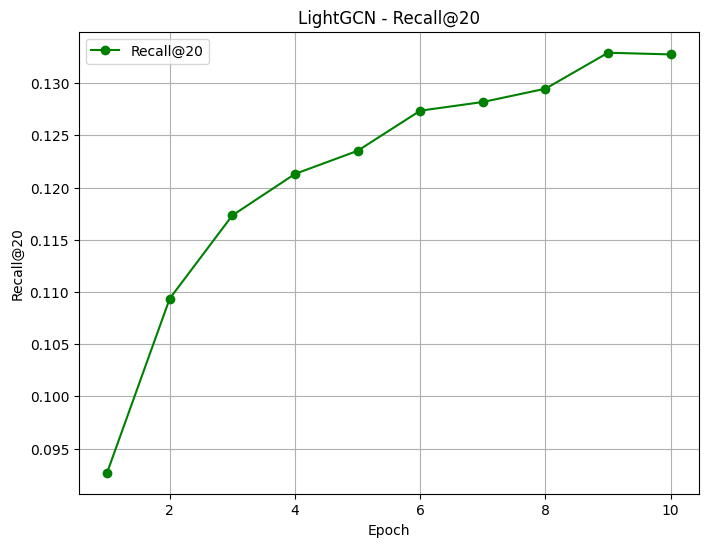

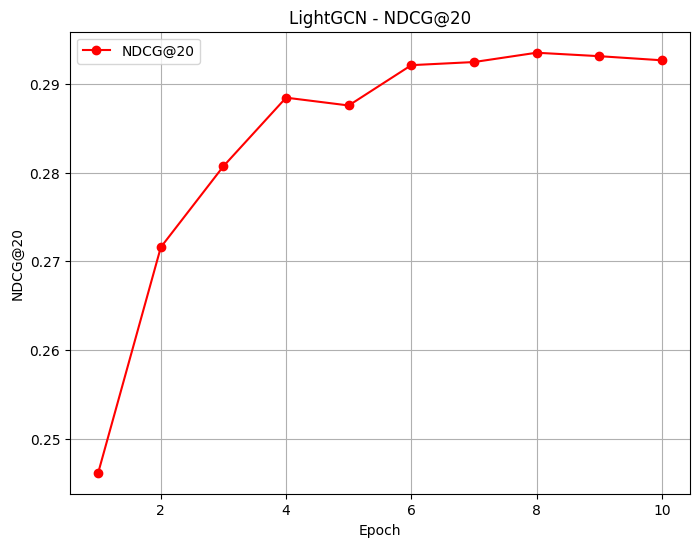


Evaluating on test data...

Evaluation Results (k=20):
  Recall@20:    0.132522
  NDCG@20:      0.300852


In [ ]:
import json
import numpy as np
import scipy.sparse as sp
import tensorflow as tf
import random
from tensorflow.keras.utils import Progbar
import matplotlib.pyplot as plt
from collections import defaultdict

def load_mydataset(train_file, test_file, val_file):
    def read_json(path):
        with open(path, 'r') as f:
            return [set(x) for x in json.load(f)]

    train_list = read_json(train_file)
    test_list = read_json(test_file)
    val_list = read_json(val_file)

    train_items = {item for items in train_list for item in items}

    def filter_orphans(data_list, valid_items):
        # remove items not appear in train set
        return [{item for item in items if item in valid_items} for items in data_list]

    test_list = filter_orphans(test_list, train_items)
    val_list = filter_orphans(val_list, train_items)

    n_users = len(train_list)
    n_items = max(train_items) + 1 if train_items else 0

    return train_list, test_list, val_list, n_users, n_items

def build_adjacency_matrix(train_data, n_users, n_items):
    # Create a bipartite adjacency matrix [0, R; R^T, 0].
    R_dok = sp.dok_matrix((n_users, n_items), dtype=np.float32)
    for u, items in enumerate(train_data):
        for i in items:
            R_dok[u, i] = 1.0
    R_csr = R_dok.tocsr()

    adj_size = n_users + n_items
    adj_dok = sp.dok_matrix((adj_size, adj_size), dtype=np.float32)
    # R in the upper-right block
    adj_dok[:n_users, n_users:] = R_csr
    # R^T in the lower-left block
    adj_dok[n_users:, :n_users] = R_csr.transpose()
    return adj_dok.tocsr()


def normalize_adj_sym(adj_mat):
    # Perform symmetric normalization: D^-1/2 * A * D^-1/2.
    rowsum = np.array(adj_mat.sum(axis=1)).flatten() + 1e-9
    d_inv_sqrt = np.power(rowsum, -0.5)
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.0
    D_inv_sqrt = sp.diags(d_inv_sqrt)
    return D_inv_sqrt.dot(adj_mat).dot(D_inv_sqrt)

class LightGCNModel(tf.keras.Model):
    def __init__(self, n_users, n_items, adj_mat, n_layers=3, emb_dim=64, decay=1e-4, use_personalized_alpha=False):
        super().__init__()
        self.n_users = n_users
        self.n_items = n_items
        self.adj_mat = adj_mat  # TF SparseTensor
        self.n_layers = n_layers
        self.emb_dim = emb_dim
        self.decay = decay
        self.use_personalized_alpha = use_personalized_alpha

        # Initialize embeddings
        initializer = tf.initializers.GlorotUniform()
        self.user_embedding = self.add_weight(
            name='user_embedding',
            shape=(n_users, emb_dim),
            initializer=initializer,
            trainable=True
        )
        self.item_embedding = self.add_weight(
            name='item_embedding',
            shape=(n_items, emb_dim),
            initializer=initializer,
            trainable=True
        )

        if use_personalized_alpha:
            self.alpha_weights = self.add_weight(
                name='alpha_weights',
                shape=(n_layers + 1, n_users),  # One weight per user per layer
                initializer=tf.initializers.GlorotUniform(),
                trainable=True
            )

    def call(self, embeddings):
        user_emb, item_emb = embeddings
        all_emb = tf.concat([user_emb, item_emb], axis=0)
        emb_list = [all_emb]

        # propagation layers
        for _ in range(self.n_layers):
            all_emb = tf.sparse.sparse_dense_matmul(self.adj_mat, all_emb)
            emb_list.append(all_emb)

        # combine embeddings from different layers
        if not self.use_personalized_alpha:
            # uniform average of all (K+1) layers
            alpha_k = 1.0 / (self.n_layers + 1)
            alpha_weights = [alpha_k] * (self.n_layers + 1)
            alpha_weights = tf.convert_to_tensor(alpha_weights, dtype=tf.float32)
            alpha_weights = tf.reshape(alpha_weights, (-1, 1, 1))
            stacked_emb = tf.stack(emb_list, axis=0)  # shape (K+1, n_users+n_items, emb_dim)
            combined_emb = tf.reduce_sum(stacked_emb * alpha_weights, axis=0)
        else:
           # normalize alpha_weights using softmax
            alpha_weights = tf.nn.softmax(self.alpha_weights, axis=0)  # Shape: (K+1, n_users)
        
            # stack embeddings for users
            stacked_user_embs = tf.stack([emb[:self.n_users] for emb in emb_list], axis=0)  # (K+1, n_users, emb_dim)
        
            # weighted sum -> user embeddings
            alpha_weights = tf.expand_dims(alpha_weights, axis=-1)  # Shape: (K+1, n_users, 1)
            weighted_user_emb = tf.reduce_sum(stacked_user_embs * alpha_weights, axis=0)  # (n_users, emb_dim)
        
            # items -> uniform combination
            stacked_item_embs = tf.stack([emb[self.n_users:] for emb in emb_list], axis=0)  # (K+1, n_items, emb_dim)
            weighted_item_emb = tf.reduce_mean(stacked_item_embs, axis=0)  # Uniform average for items
        
            combined_emb = tf.concat([weighted_user_emb, weighted_item_emb], axis=0)
        

        user_final, item_final = tf.split(combined_emb, [self.n_users, self.n_items], axis=0)
        return user_final, item_final

    def recommend(self, user_ids, k=10):
        updated_user_emb, updated_item_emb = self((self.user_embedding, self.item_embedding))
        user_vecs = tf.gather(updated_user_emb, user_ids)

        all_recs = []
        for idx, uid in enumerate(user_ids):
            u_vec = user_vecs[idx:idx + 1]
            scores = tf.matmul(u_vec, updated_item_emb, transpose_b=True)  # shape=(1, n_items)
            scores_np = scores.numpy().flatten()
            idx_topk = np.argsort(scores_np)[::-1][:k]
            score_topk = scores_np[idx_topk]
            for item_id, sc in zip(idx_topk, score_topk):
                all_recs.append((int(uid), int(item_id), float(sc)))
        return all_recs


def sample_neg(pos_items, n_items, strategy='random'):
    if strategy == 'random':
        neg_item = random.randint(0, n_items - 1)
        while neg_item in pos_items:
            neg_item = random.randint(0, n_items - 1)
    return neg_item


def train_lightgcn(model, train_data, val_data, n_users, n_items, batch_size=1024, epochs=10, initial_lr=1e-2):
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=initial_lr,
        decay_steps=1000,
        decay_rate=0.96,
        staircase=True
    )
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    train_pairs = [(u, i) for u in range(n_users) for i in train_data[u]]
    steps_per_epoch = len(train_pairs) // batch_size + (len(train_pairs) % batch_size != 0)

    epoch_losses = []
    recall_history = []
    ndcg_history = []

    val_users = [u for u in range(n_users) if len(val_data[u]) > 0]

    for epoch in range(1, epochs + 1):
        random.shuffle(train_pairs)
        progbar = Progbar(steps_per_epoch)

        epoch_loss = 0.0

        for step in range(steps_per_epoch):
            batch_slice = train_pairs[step * batch_size : (step + 1) * batch_size]
            users = [u for (u, _) in batch_slice]
            pos_items = [i for (_, i) in batch_slice]
            neg_items = [sample_neg(train_data[u], n_items) for (u, _) in batch_slice]

            users = np.array(users, dtype=np.int32)
            pos_items = np.array(pos_items, dtype=np.int32)
            neg_items = np.array(neg_items, dtype=np.int32)

            with tf.GradientTape() as tape:
                user_emb, item_emb = model((model.user_embedding, model.item_embedding))
                u_emb = tf.nn.embedding_lookup(user_emb, users)
                pos_emb = tf.nn.embedding_lookup(item_emb, pos_items)
                neg_emb = tf.nn.embedding_lookup(item_emb, neg_items)

                pos_scores = tf.reduce_sum(u_emb * pos_emb, axis=1)
                neg_scores = tf.reduce_sum(u_emb * neg_emb, axis=1)
                mf_loss = tf.reduce_mean(tf.nn.softplus(neg_scores - pos_scores))

                reg_loss = model.decay * (
                    tf.nn.l2_loss(u_emb) + tf.nn.l2_loss(pos_emb) + tf.nn.l2_loss(neg_emb)
                ) / batch_size

                if model.use_personalized_alpha:
                    reg_alpha = tf.reduce_sum(tf.nn.l2_loss(model.alpha_weights)) * 1e-4
                    loss = mf_loss + reg_loss + reg_alpha
                else:
                    loss = mf_loss + reg_loss

            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            epoch_loss += loss.numpy()
            progbar.add(1, values=[('loss', float(loss))])

        avg_epoch_loss = epoch_loss / steps_per_epoch
        epoch_losses.append(avg_epoch_loss)
        print(f"Epoch {epoch}/{epochs} - Avg loss: {avg_epoch_loss:.6f}")

        if len(val_users) > 0:
            recs_val = model.recommend(val_users, k=20)
            epoch_recall = recall_at_k(recs_val, val_data, k=20)
            epoch_ndcg = ndcg(recs_val, val_data, k=20)
            recall_history.append(epoch_recall)
            ndcg_history.append(epoch_ndcg)
            print(f"  [Val] Recall@20: {epoch_recall:.4f}  NDCG@20: {epoch_ndcg:.4f}")
        else:
            recall_history.append(0)
            ndcg_history.append(0)

    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o', linestyle='-',
             color='b', label="Loss")
    plt.title("LightGCN - Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(recall_history) + 1), recall_history, marker='o', linestyle='-',
             color='g', label="Recall@20")
    plt.title("LightGCN - Recall@20")
    plt.xlabel("Epoch")
    plt.ylabel("Recall@20")
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(ndcg_history) + 1), ndcg_history, marker='o', linestyle='-',
             color='r', label="NDCG@20")
    plt.title("LightGCN - NDCG@20")
    plt.xlabel("Epoch")
    plt.ylabel("NDCG@20")
    plt.grid(True)
    plt.legend()
    plt.show()

def recall_at_k(recs, test_data, k=10):
    user_recs = defaultdict(list)
    for (u, i, s) in recs:
        user_recs[u].append(i)
    recalls = []
    for u, items_pred in user_recs.items():
        if len(test_data[u]) == 0:
            continue
        if k > 0:
            items_pred = items_pred[:k]
        gt = test_data[u]
        num_hit = len(set(items_pred).intersection(gt))
        recalls.append(num_hit / float(len(gt)))
    return np.mean(recalls) if recalls else 0.0

def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(r / np.log2(np.arange(2, r.size + 2)))
    return 0.

def ndcg_at_k(recommended, ground_truth, k=10):
    rel = [1 if i in ground_truth else 0 for i in recommended[:k]]
    ideal_rel = sorted(rel, reverse=True)
    dcg = dcg_at_k(rel, k)
    idcg = dcg_at_k(ideal_rel, k)
    return (dcg / idcg) if idcg > 0 else 0.0

def ndcg(recs, test_data, k=10):
    user_recs = defaultdict(list)
    for (u, i, s) in recs:
        user_recs[u].append(i)
    ndcgs = []
    for u, items_pred in user_recs.items():
        gt = test_data[u]
        if len(gt) == 0:
            continue
        ndcgs.append(ndcg_at_k(items_pred, gt, k))
    return np.mean(ndcgs) if ndcgs else 0.0


def evaluate_lightgcn(model, users, test_data, ks=[5, 10, 20], batch_size=2000):
    all_recs = []
    idx_start = 0
    max_k = max(ks)
    while idx_start < len(users):
        idx_end = min(idx_start + batch_size, len(users))
        user_batch = users[idx_start:idx_end]
        recs_chunk = model.recommend(user_batch, k=max_k)
        all_recs.extend(recs_chunk)
        idx_start = idx_end

    results = {}
    for k in ks:
        rec = recall_at_k(all_recs, test_data, k=k)
        ndcg_ = ndcg(all_recs, test_data, k=k)
        results[k] = (rec, ndcg_)
        print(f"\nEvaluation Results (k={k}):")
        print(f"  Recall@{k}:    {rec:.6f}")
        print(f"  NDCG@{k}:      {ndcg_:.6f}")

    return results


train_file = '/kaggle/input/dataset-movielens/train_data.json'
test_file = '/kaggle/input/dataset-movielens/test_data.json'
val_file = '/kaggle/input/dataset-movielens/validation_data.json'

train_data, test_data, val_data, n_users, n_items = load_mydataset(
    train_file, test_file, val_file
)
print(f"Number of Users: {n_users}, Number of Items: {n_items}")

adj_csr = build_adjacency_matrix(train_data, n_users, n_items)
norm_adj_csr = normalize_adj_sym(adj_csr)

# convert to TensorFlow SparseTensor
coo = norm_adj_csr.tocoo().astype(np.float32)
indices = np.vstack((coo.row, coo.col)).transpose()
A_tilde = tf.sparse.SparseTensor(indices=indices, values=coo.data, dense_shape=coo.shape)
A_tilde = tf.sparse.reorder(A_tilde)

N_LAYERS = 5
EMBED_DIM = 64
DECAY = 1e-3
INITIAL_LR = 1e-2
EPOCHS = 10
BATCH_SIZE = 1024

model = LightGCNModel(
    n_users=n_users,
    n_items=n_items,
    adj_mat=A_tilde,
    n_layers=N_LAYERS,
    emb_dim=EMBED_DIM,
    decay=DECAY,
    use_personalized_alpha=True
)

print("\nStarting LightGCN training...")
train_lightgcn(
    model=model,
    train_data=train_data,
    val_data=val_data,
    n_users=n_users,
    n_items=n_items,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    initial_lr=INITIAL_LR
)

print("\nEvaluating on test data...")
test_users = [u for u in range(n_users) if len(test_data[u]) > 0]
_ = evaluate_lightgcn(model, test_users, test_data, ks=[20])